In this run, downscale the images even further???,

and normalize dataset using torchvision directly

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from torchvision.transforms import v2
import torchvision
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torchgeo.datasets import RasterDataset, IntersectionDataset, stack_samples, unbind_samples, random_bbox_assignment
from torchgeo.samplers import RandomGeoSampler, RandomBatchGeoSampler, GridGeoSampler
from torchgeo.datamodules import GeoDataModule
import rasterio
import torchsummary
import os
import re
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# MLP Approach
Here we implement a multilayer perceptron to start exploring the provided segmentation datasets and also to have a first approach to segmentation.

Reference projs, docs & papers:
* [Paper] [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1411.4038)
* [Web] [A complete guide to semantic segmentation in 2024](https://nanonets.com/blog/semantic-image-segmentation-2020/)


**NOTE:**
> For this delivery, we are not supposed to use convolutional networks, hence we will extract some ideas from the paper listed above, but in the end we will just have a multilayer perceptron.

In [39]:
import torch
if torch.backends.mps.is_available():
	mps_device = torch.device("mps")
	x = torch.ones(1, device=mps_device)
	print(x)
elif torch.cuda.is_available():
	cuda_device = torch.device("cuda")
	x = torch.ones(1, device=cuda_device)
	print(x)

	print(torch.cuda.get_device_name(0))
	print('Memory Usage:')
	print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
	print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
	
else:
	print("MPS device not found.")

tensor([1.], device='cuda:0')
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.3 GB
Cached:    0.9 GB


## Image Loader

In [40]:
dataset_path = './datasets/Inria/AerialImageDataset/train'
# test_path = './datasets/Inria/AerialImageDataset/test'

In [41]:
x = rasterio.open(os.path.join(dataset_path, 'images/austin1.tif'))
x = x.read()
print(x.shape) # (channels, rows, cols)

(3, 5000, 5000)


In [42]:
y = rasterio.open(os.path.join(dataset_path, 'gt/austin1.tif'))
y = y.read()
print(y.shape)

(1, 5000, 5000)


In this case:
* Input: Patches of 5000x5000x3 (3 channels - RGB)
* Output: Patches of 5000x5000x1 (1 channel - segmentation map)

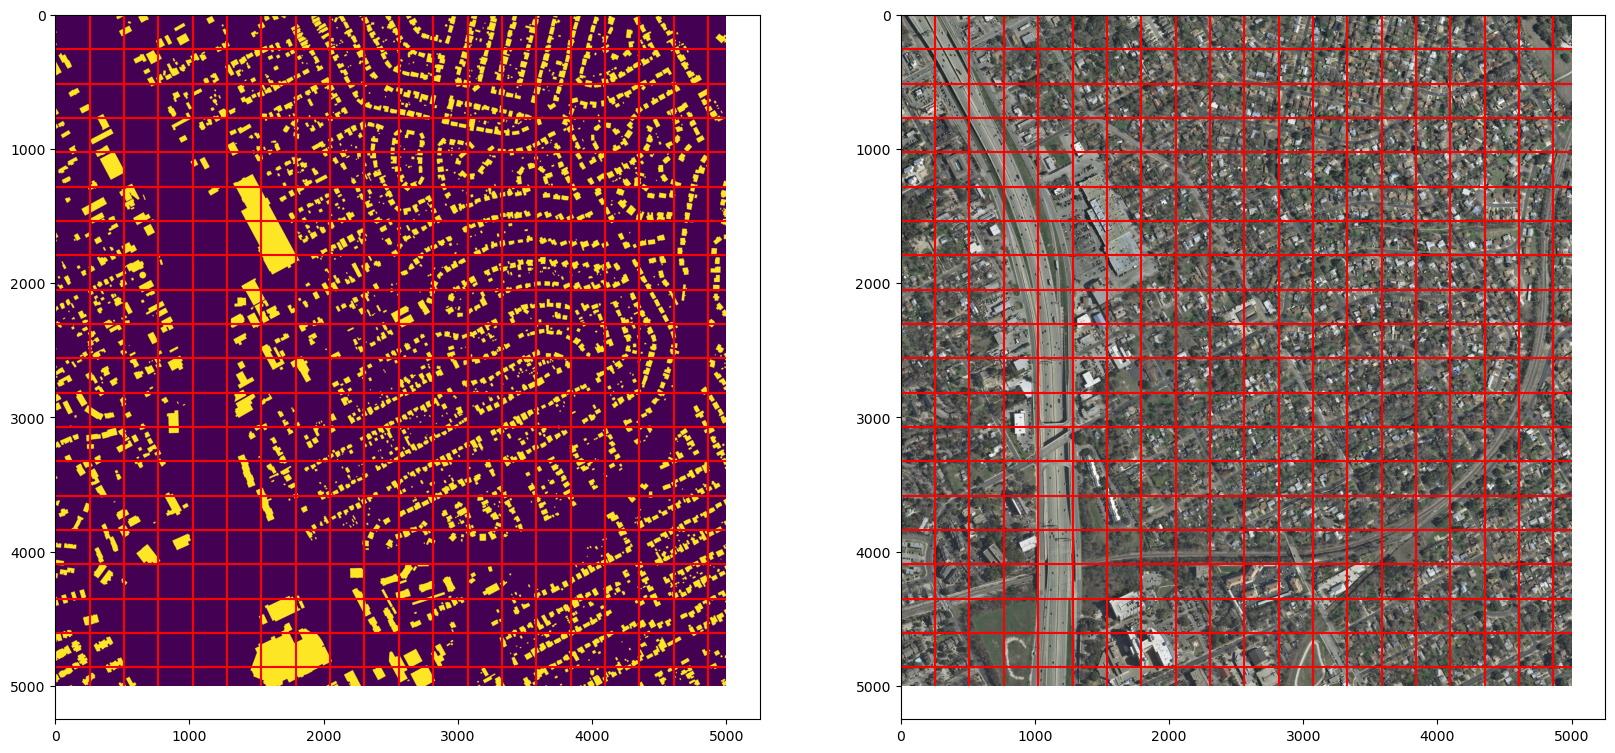

In [43]:
def plot_tiles(ax, tile_size, h, w):
	ax.vlines(list(range(0, h, tile_size)), 0, w, color='red')
	ax.hlines(list(range(0, w, tile_size)), 0, h, color='red')

tile_size = 256

fig, axs = plt.subplots(1, 2, figsize=(20, 20))
axs[0].imshow(y.T)
plot_tiles(axs[0], tile_size, y.shape[1], y.shape[2])

axs[1].imshow(x.T)
plot_tiles(axs[1], tile_size, x.shape[1], x.shape[2])
plt.show()


**Torchgeo Dataset**

In [44]:
def plot_images(base_plot_size=4, **images):
	n = len(images)
	siz = base_plot_size * n
	fig, axs = plt.subplots(1,n, figsize=(siz, base_plot_size))

	for i, (name, image) in enumerate(images.items()):
		if n > 1:
			axs[i].set_title(name)
			axs[i].imshow(image)
			axs[i].axis('off')
		else:
			axs.set_title(name)
			axs.imshow(image)
	plt.tight_layout()

In [45]:
class RGBLoader(RasterDataset):
	filename_glob = '*.tif'
	is_image=True
	separate_files=False
	# all_bands=('B01', 'B02', 'B03')
	# rgb_bands=('B01', 'B02', 'B03')

class SegmentationMapLoader(RasterDataset):
	filename_glob = '*.tif'
	is_image=False # False means is a segmentation mask
	dtype=torch.float32 # Override to be used in pixel-wise regression
	separate_files=False

In [128]:
def transform_image(x, kernels, key='image', grayscale_mode=False):
	is_dict = type(x) is dict

	image = x[key] if is_dict else x

	squeeze_flag = len(image.shape) < 3

	if squeeze_flag:
		image = image.unsqueeze(0)
	
	result = [image.squeeze() / 255] # Instead of doing processing with identity kernel (also scale it to 0,1)

	for k in kernels:
		if grayscale_mode:
			out = F.conv2d(
				v2.Grayscale()(image),
				torch.tensor([[k]], dtype=torch.float32), 
				groups=1,
				padding=1
			)
			_min, _max = torch.aminmax(out) # scale to 0,1
			out = (out - _min) / (_max - _min)
			result.append(out)
		else:
			out = F.conv2d(
				image,
				torch.tensor([[k],[k],[k]], dtype=torch.float32),
				groups=3,
				padding=1
			)
			_min, _max = torch.aminmax(out) # scale to 0,1
			out = (out - _min) / (_max - _min)
			result.append(out.squeeze())
			
	result = torch.concat(result)

	if (squeeze_flag):
		image = image.squeeze()
	
	if is_dict:
		return {**x, key: result}
	return result

Testing kernels & create dataloaders

In [129]:
# Read:
# https://setosa.io/ev/image-kernels/
# https://www.geeksforgeeks.org/types-of-convolution-kernels/#2-edge-detection-kernels

# # Identity
# k1 = [
#   [0, 0, 0],
#   [0, 1, 0],
#   [0, 0, 0]
# ]

# Emboss
k2 = [
	[-2, -1, 0],
	[-1, 1, 1],
	[0, 1, 2]
]

# Edge Detection (Outline)
k3 = [
	[-1, -1, -1],
	[-1, 8, -1],
	[-1, -1, -1]
]

kernels = [k2, k3]

In [130]:
grayscale_mode=True

segmentation_transforms = v2.Compose([
	v2.Resize(size=64, interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT),
  # v2.ToDtype(torch.float32, scale=True)
])

images_transforms = v2.Compose([
	v2.Resize(size=64),
	lambda x: transform_image(x, kernels, grayscale_mode=grayscale_mode),
])


images_dataset = RGBLoader(os.path.join(dataset_path, 'images/'), transforms=images_transforms)
segmentation_map_dataset = SegmentationMapLoader(os.path.join(dataset_path, 'gt/'), transforms=segmentation_transforms)
dataset = images_dataset & segmentation_map_dataset # Intersection Dataset

print(images_dataset)
print(segmentation_map_dataset)
print(dataset)

Converting SegmentationMapLoader res from 0.3 to 0.29999999999997673
RGBLoader Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=-1281274.2289648587, maxx=5353879.269352469, miny=3343500.0, maxy=12340611.831173468, mint=0.0, maxt=9.223372036854776e+18)
    size: 180
SegmentationMapLoader Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=-1281274.2289648587, maxx=5353879.269352469, miny=3343500.0, maxy=12340611.831173468, mint=0.0, maxt=9.223372036854776e+18)
    size: 180
IntersectionDataset Dataset
    type: IntersectionDataset
    bbox: BoundingBox(minx=-1281274.2289648587, maxx=5353879.269352469, miny=3343500.0, maxy=12340611.831173468, mint=0.0, maxt=9.223372036854776e+18)
    size: 994


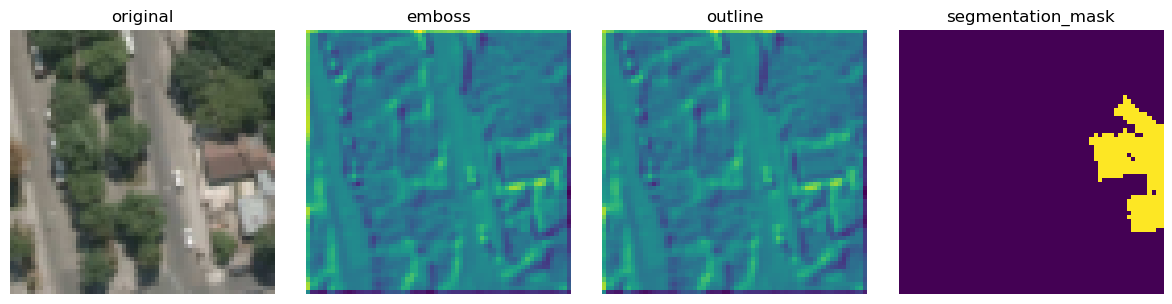

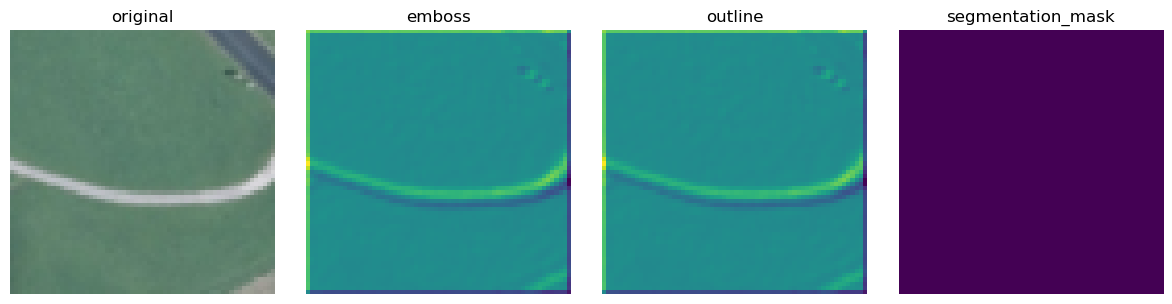

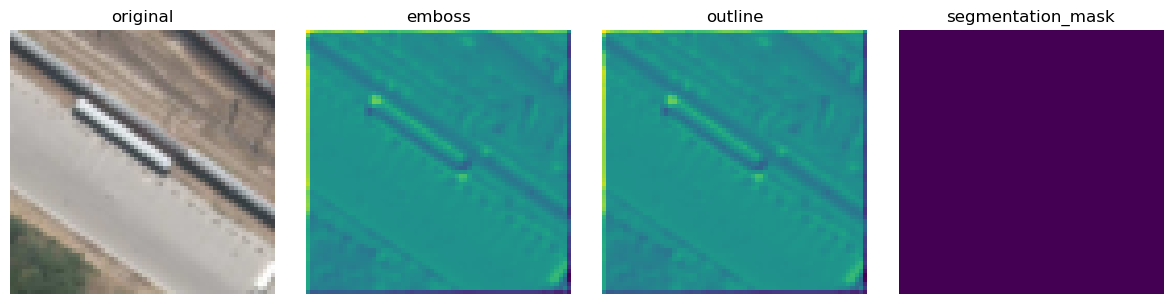

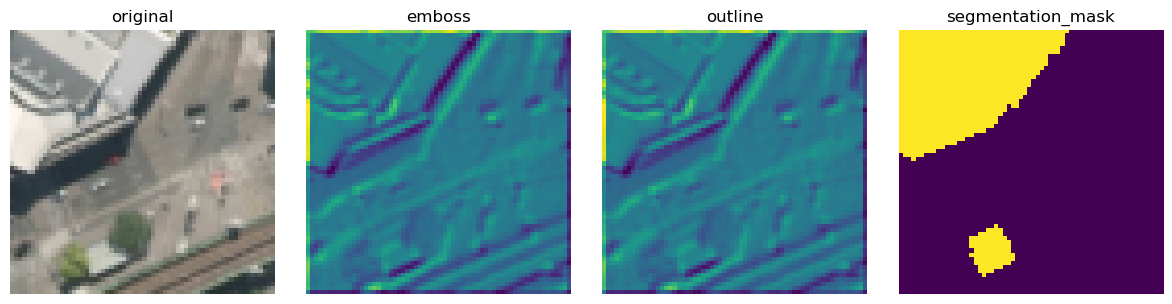

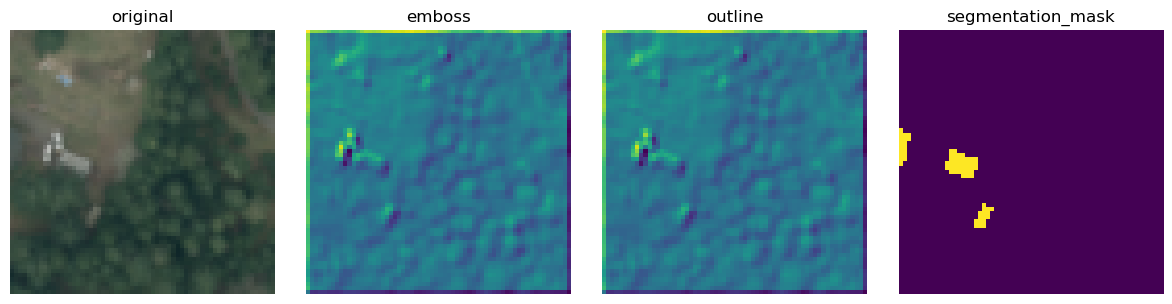

In [132]:
sampler = RandomGeoSampler(dataset, size=256, length=10) # patches of size 256, but resized by the transforms above
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

n=0
for sample in dataloader:
	if n==5: break
	
	image, gt = sample['image'], sample['mask']

	image_original = image.squeeze()[:3] #k1

	image_emboss = image.squeeze()[3:6] if not grayscale_mode else image.squeeze()[3] #k2
	# _min, _max = torch.aminmax(image_emboss)
	# image_emboss = (image_emboss - _min) / (_max - _min)

	image_outline = image.squeeze()[6:9] if not grayscale_mode else image.squeeze()[4] #k3
	# _min, _max = torch.aminmax(image_outline)
	# image_outline = (image_outline - _min) / (_max - _min)


	plot_images(
		base_plot_size=3,
		original=v2.ToPILImage(mode='RGB')(image_original),
		emboss=v2.ToPILImage(mode='RGB')(image_emboss) if not grayscale_mode else image_emboss,
		outline=v2.ToPILImage(mode='RGB')(image_outline) if not grayscale_mode else image_emboss,
		segmentation_mask=gt.squeeze()/255
	)
	n+=1

In [126]:
image.shape

torch.Size([1, 5, 64, 64])

In [ ]:
image.shape

torch.Size([1, 5, 64, 64])

**Dataset split (train/test) and DataLoader**
> Note: In the end, we didn't use this, instead used Lighthing DataModules

In [14]:
# Get count per city from train folder
# (keep in mind that test does not have the ground truth, so we will do a 80/20 split over the train folder)

filenames = os.listdir(os.path.join(dataset_path, 'gt'))
train_filenames, test_filenames = train_test_split(filenames, test_size=0.2, random_state=1234)
train_test_filenames = [train_filenames, test_filenames]


# Copy to split_dataset folder (actually, it creates symlinks)
train_path = './datasets/Inria/AerialImageDataset/split_dataset/train/'
test_path = './datasets/Inria/AerialImageDataset/split_dataset/test/'
train_test_paths = [train_path, test_path]

for path, files in zip(train_test_paths, train_test_filenames):
	shutil.rmtree(path, ignore_errors=True)
	os.makedirs(os.path.join(path, 'images'), exist_ok=True)
	os.makedirs(os.path.join(path, 'gt'), exist_ok=True)

	for file in files:
		src = os.path.abspath(os.path.join(dataset_path, 'images', file))
		dst = os.path.abspath(os.path.join(path, 'images', file))
		os.symlink(src, dst)

		src = os.path.abspath(os.path.join(dataset_path, 'gt', file))
		dst = os.path.abspath(os.path.join(path, 'gt', file))
		os.symlink(src, dst)

print("# images:", len(filenames))
print(f"Split: (train = {len(train_filenames)}, test = {len(test_filenames)})")


# images: 180
Split: (train = 144, test = 36)


In [15]:
img_size = 256 # window size
sample_size = 500
batch_size = 32

train_dataset = RGBLoader(os.path.join(train_path, 'images/')) & SegmentationMapLoader(os.path.join(train_path, 'gt/'))
test_dataset = RGBLoader(os.path.join(test_path, 'images/')) & SegmentationMapLoader(os.path.join(test_path, 'gt/'))

train_dataloader = DataLoader(
	train_dataset,
	batch_size=batch_size,
	sampler=RandomGeoSampler(train_dataset, size=img_size, length=sample_size), # random sampling
	collate_fn=stack_samples,
)

test_dataloader = DataLoader(
	test_dataset,
	batch_size=32,
	sampler=RandomGeoSampler(test_dataset, size=img_size, length=sample_size),
	collate_fn=stack_samples,
)

Converting SegmentationMapLoader res from 0.3 to 0.29999999999997673
Converting SegmentationMapLoader res from 0.3 to 0.29999999999997673


In [16]:
batch =next(iter(test_dataloader))

In [17]:
batch['image'].shape

torch.Size([32, 3, 256, 256])

## Model


Samplers & data loaders:
* https://torchgeo.readthedocs.io/en/stable/tutorials/custom_raster_dataset.html
* https://torchgeo.readthedocs.io/en/latest/api/datasets.html#torchgeo.datasets.IntersectionDataset
* https://torchgeo.readthedocs.io/en/stable/api/samplers.html

Loses:
* https://torchgeo.readthedocs.io/en/latest/api/losses.html

Ref:
* https://www.kaggle.com/code/luizclaudioandrade/semantic-segmentation-torchgeo


**NOTE:**
> As stated at the beggining of the notebook, we will build the model as a MLP

**Dataset subsample**

Taking a subsample (I don't think this model will perform better than a CNN, just for testing purposes and fast iteration, just use half the dataset)

In [18]:
# Get count per city from train folder
# (keep in mind that test does not have the ground truth, so we will do a 80/20 split over the train folder)

cities = ['chicago', 'vienna']
cities = "|".join(cities)

filenames = os.listdir(os.path.join(dataset_path, 'gt'))
subsample_filenames = [f for f in filenames if re.match(rf'({cities}).*', f)]
# subsample_filenames, _ = train_test_split(filenames, test_size=0.5, random_state=1234)

subsample_path = './datasets/Inria/AerialImageDataset/subsample/train/'

shutil.rmtree(subsample_path, ignore_errors=True)
os.makedirs(os.path.join(subsample_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(subsample_path, 'gt'), exist_ok=True)

for file in subsample_filenames:
	src = os.path.abspath(os.path.join(dataset_path, 'images', file))
	dst = os.path.abspath(os.path.join(subsample_path, 'images', file))
	os.symlink(src, dst)

	src = os.path.abspath(os.path.join(dataset_path, 'gt', file))
	dst = os.path.abspath(os.path.join(subsample_path, 'gt', file))
	os.symlink(src, dst)


print("# images:", len(filenames))
print(f"(subsample of {len(subsample_filenames)})")


# images: 180
(subsample of 72)


**Defnining DataModule (lightning)**

*Better use data modules to handle the whole process, and handle train/test/validate split from there*

In [11]:
class CustomGeoDataModule(GeoDataModule): # Geodamatodule extends from torch lightning DataModules
	def __init__(self, **kwargs):
		super().__init__(
			dataset_class=kwargs['dataset_class'],
			batch_size=kwargs['batch_size'],
			patch_size=kwargs['patch_size'],
			length=kwargs['length'],
			num_workers=kwargs['num_workers'],
			**kwargs['dataset_class_kwargs']
		)
		# keep in mind that super method will set kwargs object attribute as kwargs['dataset_class_kwargs']
		self.split_faction = kwargs.get('split_fraction', [0.6, 0.2, 0.2])
		self.seed = kwargs.get('seed')

	def setup(self, stage):
		# self.dataset = self.dataset_class(**self.kwargs)
		self.dataset = self.kwargs['dataset1'] & self.kwargs['dataset2']

		generator = torch.Generator().manual_seed(self.seed)
		(self.train_dataset, self.val_dataset, self.test_dataset) = random_bbox_assignment(self.dataset, self.split_faction, generator)

		if stage in ["fit"]:
			self.train_batch_sampler = RandomBatchGeoSampler(self.train_dataset, self.patch_size, self.batch_size, self.length)
		if stage in ["fit", "validate"]:
			self.val_sampler = GridGeoSampler(self.val_dataset, self.patch_size, self.patch_size)
		if stage in ["test"]:
			self.test_sampler = GridGeoSampler(self.test_dataset, self.patch_size, self.patch_size)
			

In [12]:
subsample_path = './datasets/Inria/AerialImageDataset/subsample/train/'
patch_size = 256 # Patch size
sample_size = 500
batch_size = 16
n_workers = 4
split_fraction = [0.8, 0.1, 0.1]


image_size = 64
mask_size = 32


images_transforms = v2.Compose([
	v2.Resize(size=image_size),
	# lambdaWrapper,
])

segmentation_transforms = v2.Compose([
	v2.Resize(size=mask_size, interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT),
  # v2.ToDtype(torch.float32, scale=True)
])

images_dataset = RGBLoader(os.path.join(subsample_path, 'images/'), transforms=images_transforms)
segmentation_map_dataset = SegmentationMapLoader(os.path.join(subsample_path, 'gt/'), transforms = segmentation_transforms)

datamodule = CustomGeoDataModule(
	dataset_class = IntersectionDataset,
	batch_size = batch_size, # GeoDataModule kwargs
	patch_size = patch_size, # GeoDataModule kwargs
	length = sample_size, # GeoDataModule kwargs
	num_workers = n_workers, # GeoDataModule kwargs
	dataset_class_kwargs = dict(
		dataset1 = images_dataset, # IntersectionDataset kwargs
		dataset2 = segmentation_map_dataset, # IntersectionDataset kwargs
		collate_fn = stack_samples, # IntersectionDataset kwargs
	),
	split_fraction=split_fraction,
	seed=0,
)

**Defnining the model**

In [13]:
class MLPModel(nn.Module):
	def __init__(self, neurons_per_layer, image_size, mask_size):
		super().__init__()

		in_layer_size = 3 * image_size * image_size # C * H, W (channels = 9 due to the convolution filters applied)
		out_layer_size = 1 * mask_size * mask_size # C * H * W (channels = 1)
		
		linear_layers = []
		neurons_per_layer = [in_layer_size] + neurons_per_layer
		
		for i in range(1, len(neurons_per_layer)):
			in_size = neurons_per_layer[i - 1]
			out_size = neurons_per_layer[i]

			linear_layers.append(nn.Linear(in_size, out_size))
			linear_layers.append(nn.ReLU())
		
		self.model = nn.Sequential(
			nn.Flatten(),
			*linear_layers,
			nn.Linear(neurons_per_layer[-1], out_layer_size),
			nn.Unflatten(1, (mask_size, mask_size)),
			nn.Sigmoid()
		)
	def forward(self, x):
		return self.model(x)



**Lightning Module**

In [14]:
class MLPSegmentationModel(L.LightningModule):
	def __init__(self, neurons_per_layer, image_size, mask_size):
		super().__init__()
		self.model = MLPModel(neurons_per_layer, image_size, mask_size)
		self.save_hyperparameters()

	def forward(self, x):
		batch_size, channels, h, w = x.shape
		return self.model(x)
		
	def training_step(self, batch, batch_idx):
		x = batch['image']
		y = batch['mask'] / 255 # normalize, it was not normalized, and I don't wan't to fiddle more with the transforms, I'm tired!!!!!
		y_pred = self(x)
		loss = F.binary_cross_entropy_with_logits(y_pred, y) # because I added the sigmoid layer
		# loss = F.mse_loss(y_pred, y)

		self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
		return loss

	def validation_step(self, batch, batch_idx):
		x = batch['image']
		y = batch['mask'] / 255 # normalize
		y_pred = self(x)
		loss = F.binary_cross_entropy_with_logits(y_pred, y) # because I added the sigmoid layer
		# loss = F.mse_loss(y_pred, y)

		self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
		return loss
	
	@torch.no_grad()
	def test_step(self, batch, batch_idx):
		x = batch['image']
		y = batch['mask'] / 255 # normalize
		y_pred = self(x)
		loss = F.binary_cross_entropy_with_logits(y_pred, y) # because I added the sigmoid layer
		# loss = F.mse_loss(y_pred, y)
		self.log('test_loss', loss)
		return loss
	
	def on_train_epoch_start(self):
		# Log the learning rate
		optimizer = self.trainer.optimizers[0]
		lr = optimizer.param_groups[0]['lr']
		self.log('learning_rate', lr, on_epoch=True, prog_bar=True)

	def configure_optimizers(self):
		optimizer = torch.optim.SGD(self.parameters(), lr=1e-2, momentum=0.9, weight_decay=0)
		return optimizer

In [15]:
neurons_per_layer = [
	4096,
  3072,
	2048,
	2048,
	mask_size * mask_size,
	]
print("layers =", len(neurons_per_layer) + 1)
print("img_size =", image_size)
print("mask_size =", mask_size)

layers = 6
img_size = 64
mask_size = 32


In [16]:
model = MLPSegmentationModel(neurons_per_layer, image_size, mask_size)
# torchsummary.summary(model.model, (3, 128, 128))
torchsummary.summary(model.model, (3, image_size, image_size), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 12288]               0
            Linear-2                 [-1, 4096]      50,335,744
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 3072]      12,585,984
              ReLU-5                 [-1, 3072]               0
            Linear-6                 [-1, 2048]       6,293,504
              ReLU-7                 [-1, 2048]               0
            Linear-8                 [-1, 2048]       4,196,352
              ReLU-9                 [-1, 2048]               0
           Linear-10                 [-1, 1024]       2,098,176
             ReLU-11                 [-1, 1024]               0
           Linear-12                 [-1, 1024]       1,049,600
        Unflatten-13               [-1, 32, 32]               0
          Sigmoid-14               [-1,

### Training

In [17]:
out_path = './training_shallow/test_img_only_3/'
if not os.path.exists(out_path):
	os.makedirs(out_path)

logger = pl_loggers.CSVLogger(
	out_path,
	name='train_logs'
)

checkpoint_callback = ModelCheckpoint(
	every_n_epochs=1,
	dirpath=out_path,
	filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}',
	save_last=True,
	save_top_k=5,
	monitor='val_loss',
	mode='min',
)

early_stop_callback = EarlyStopping(
	monitor="val_loss",
	mode="min",
	patience=10,
)

trainer = Trainer(
	max_epochs=150,
	# accelerator='mps',
	accelerator='cuda',
	callbacks=[checkpoint_callback, early_stop_callback],
	logger=logger,
	# fast_dev_run=True
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model, datamodule)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/edwmapa/miniconda3/envs/mlenv_nn/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/edwmapa/Git/Proj-Redes-Neuronales-2024/training_shallow/test_img_only_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | MLPModel | 76.6 M | train
-------------------------------------------
76.6 M    Trainable params
0         Non-trainable params
76.6 M    Total params
306.237   Total estimated model params size (MB)
16        Modules in train mode
0         M

/home/edwmapa/miniconda3/envs/mlenv_nn/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 149: 100%|██████████| 31/31 [00:19<00:00,  1.62it/s, v_num=0, val_loss=0.705, learning_rate=0.010, train_loss=0.696]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 31/31 [00:22<00:00,  1.38it/s, v_num=0, val_loss=0.705, learning_rate=0.010, train_loss=0.696]


In [19]:
trainer.test(
  model=model,
  ckpt_path="last",
  datamodule=datamodule,
)

Restoring states from the checkpoint path at /home/edwmapa/Git/Proj-Redes-Neuronales-2024/training_shallow/test_img_only_3/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/edwmapa/Git/Proj-Redes-Neuronales-2024/training_shallow/test_img_only_3/last.ckpt


Testing DataLoader 0: 100%|██████████| 410/410 [00:21<00:00, 19.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7008337378501892
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7008337378501892}]

Stopped it because it plateaued around epoch 20

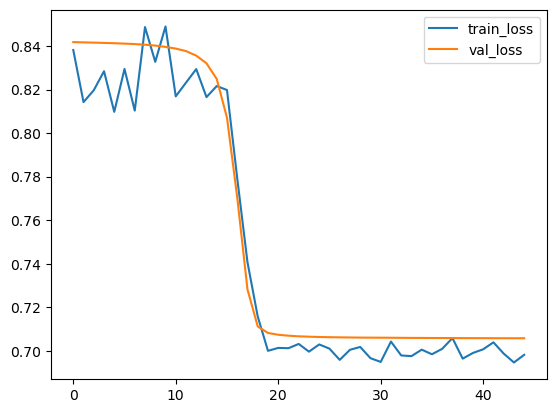

In [20]:
df = pd.read_csv('./training_shallow/test_img_only_2/train_logs/version_0/metrics.csv')
df = df.groupby(['epoch']).max().reset_index()
plt.plot(df['epoch'], df['train_loss'], label='train_loss')
plt.plot(df['epoch'], df['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Inference

In [26]:
model = MLPSegmentationModel.load_from_checkpoint(
  './training_shallow/test_img_only_3/last.ckpt',
  neurons_per_layer=neurons_per_layer,
  image_size=image_size,
  mask_size=mask_size
).to('cuda')
model.eval()


MLPSegmentationModel(
  (model): MLPModel(
    (model): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=12288, out_features=4096, bias=True)
      (2): ReLU()
      (3): Linear(in_features=4096, out_features=3072, bias=True)
      (4): ReLU()
      (5): Linear(in_features=3072, out_features=2048, bias=True)
      (6): ReLU()
      (7): Linear(in_features=2048, out_features=2048, bias=True)
      (8): ReLU()
      (9): Linear(in_features=2048, out_features=1024, bias=True)
      (10): ReLU()
      (11): Linear(in_features=1024, out_features=1024, bias=True)
      (12): Unflatten(dim=1, unflattened_size=(32, 32))
      (13): Sigmoid()
    )
  )
)

In [27]:
print(model.device)
print(model)

cuda:0
MLPSegmentationModel(
  (model): MLPModel(
    (model): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=12288, out_features=4096, bias=True)
      (2): ReLU()
      (3): Linear(in_features=4096, out_features=3072, bias=True)
      (4): ReLU()
      (5): Linear(in_features=3072, out_features=2048, bias=True)
      (6): ReLU()
      (7): Linear(in_features=2048, out_features=2048, bias=True)
      (8): ReLU()
      (9): Linear(in_features=2048, out_features=1024, bias=True)
      (10): ReLU()
      (11): Linear(in_features=1024, out_features=1024, bias=True)
      (12): Unflatten(dim=1, unflattened_size=(32, 32))
      (13): Sigmoid()
    )
  )
)


In [28]:
datamodule.setup('test')
dataloader= datamodule.test_dataloader()
iterator = iter(dataloader)

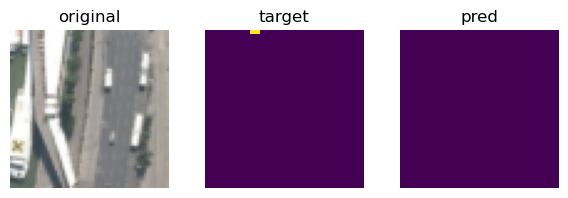

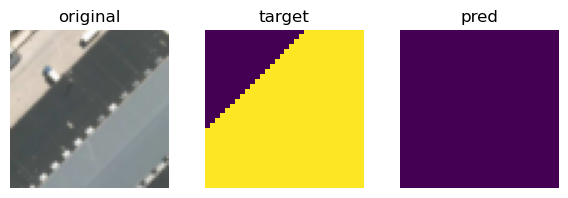

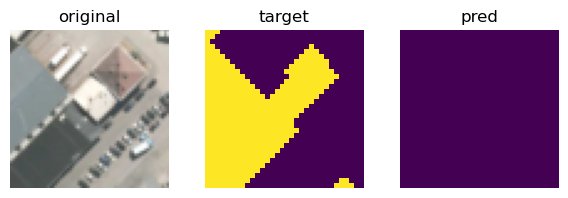

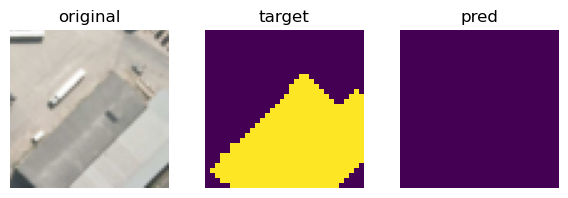

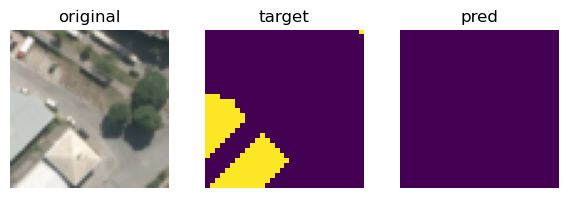

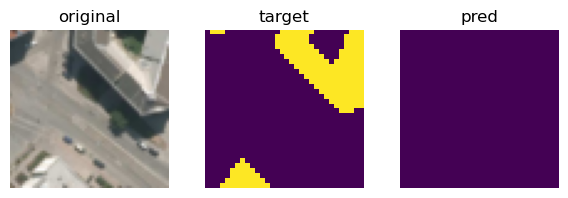

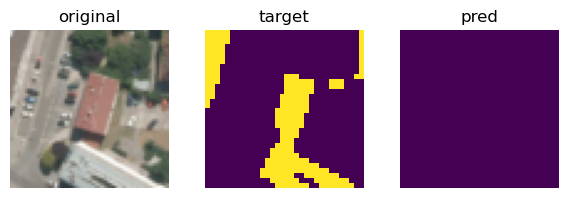

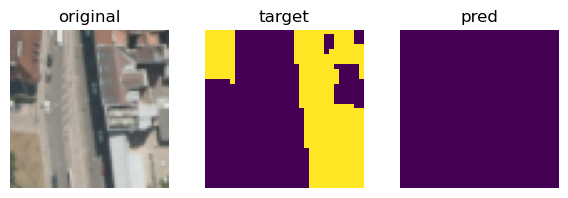

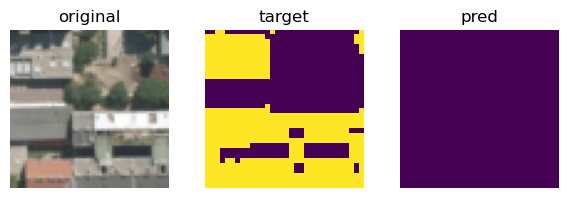

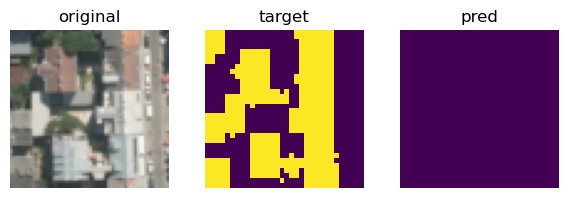

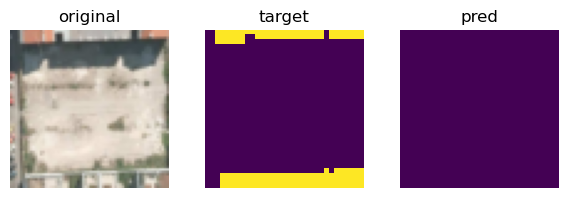

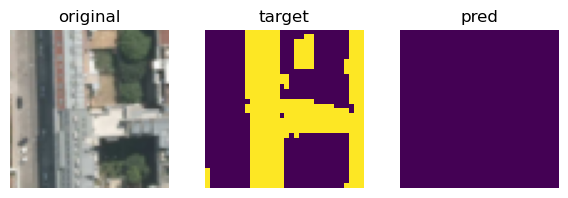

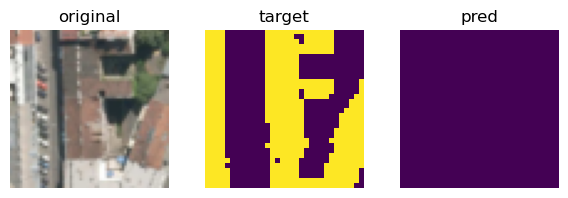

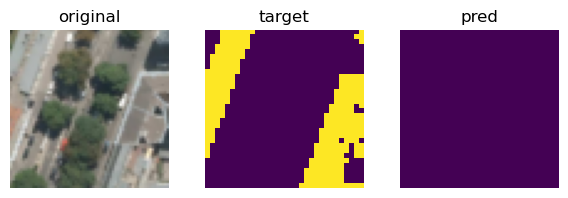

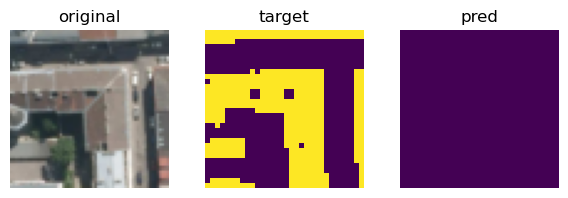

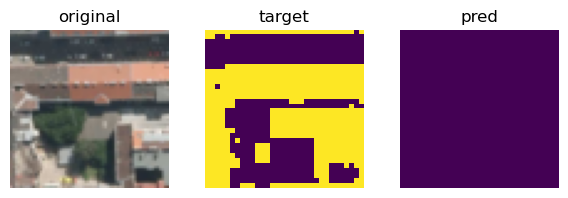

In [31]:
with torch.no_grad():
	batch = next(iterator)
	images = batch['image']
	images = images.to('cuda')
	masks = batch['mask']
	masks = masks.to('cuda')
	pred_masks = model(images)

for image, mask, pred_mask in zip(images, masks, pred_masks):
	plot_images(
		base_plot_size=2,
		original=v2.ToPILImage(mode='RGB')(image.cpu()/255),
		target=mask.cpu().squeeze()/255,
		pred=pred_mask.cpu(),
	)

In [35]:
pred_masks.min()

tensor(0., device='cuda:0')